# Continuos Regression with *KQM*: with Uncertainty

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$. However, the output of KQMU is indeed a decomposed density matrix:
$$
\sum_{i=1}^{n}\alpha_i |\phi_{y}(\hat{y}_i)\rangle \langle\phi_{y}(\hat{y}_i)|,
$$
where $\sum_i^{n}\alpha_i=1$, and $\hat{y}_i$ is a $2-\dim$ vector. Therefore we would have a set $\{\theta_i\}$ over which we can compute the expected value and variace:
$$
\mathbb{E}[\theta]=\sum_i^n\alpha_i\theta_i,
$$
$$
\sigma^2=\mathbb{E}[\theta^2]-\mathbb{E}[\theta]^2.
$$

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, classification_report, confusion_matrix, f1_score,precision_score, recall_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm

2024-08-20 14:18:46.006763: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 14:18:46.029157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 14:18:46.029175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 14:18:46.029740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 14:18:46.033779: I tensorflow/core/platform/cpu_feature_guar

### Check GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 20 14:18:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P5               8W /  40W |   6463MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## An example with a Gaussian Process

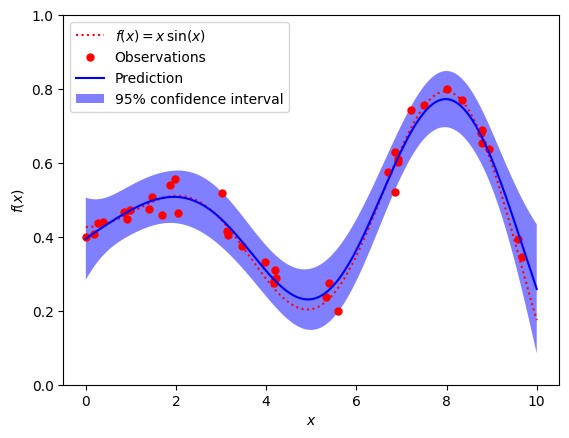

(1000, 1)


In [3]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as pl

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

x = np.atleast_2d(np.linspace(0, 10, 1000)).T

#X = np.linspace(0.1, 9.9, 20)
X = 10* np.random.random(40)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape[0])
noise = np.random.normal(0, dy)
y += noise
scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha= 0.01,# dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

## Defining KQM-Model

In [4]:
n_comp=40

In [5]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(1,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        # Extract the component weights and vectors from rho_y
        weights = rho_y[:, :, 0]  # shape: (batch_size, n_comp)
        vectors = rho_y[:, :, 1:]  # shape: (batch_size, n_comp, dim_y)
        
        # Normalize vectors
        vectors_norm = tf.sqrt(tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True))
        normalized_vectors = vectors / vectors_norm
        
        # Calculate theta from the first entry of each normalized vector
        first_entry = normalized_vectors[:, :, 0]  # shape: (batch_size, n_comp)
        thetas = tf.acos(first_entry)  # shape: (batch_size, n_comp)
        
        # Normalize weights to sum to 1
        weights_sum = tf.reduce_sum(weights, axis=-1, keepdims=True)
        normalized_weights = weights / weights_sum
        # Compute the expected value of theta
        expected_theta = tf.reduce_sum(thetas * normalized_weights, axis=-1)  # shape: (batch_size,)
        # Compute the expected value of theta squared
        expected_theta_squared = tf.reduce_sum(tf.square(thetas) * normalized_weights, axis=-1)  # shape: (batch_size,)       
        # Compute the variance using E[X²] - E[X]²
        variance_theta = expected_theta_squared - tf.square(expected_theta)  # shape: (batch_size,)        
        # Concatenate the expected value and variance
        output = tf.stack([expected_theta, variance_theta], axis=-1)  # shape: (batch_size, 2)    
        #return Model(inputs, output), kqm_unit, kernel
        return Model(inputs, output), kqm_unit, kernel
        
        #probs = kqm.dm2discrete(rho_y)
        #probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        #theta = tf.acos(probs_0_sqrt)
        #return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

2024-08-20 14:18:47.268124: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-20 14:18:47.290779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-20 14:18:47.290923: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

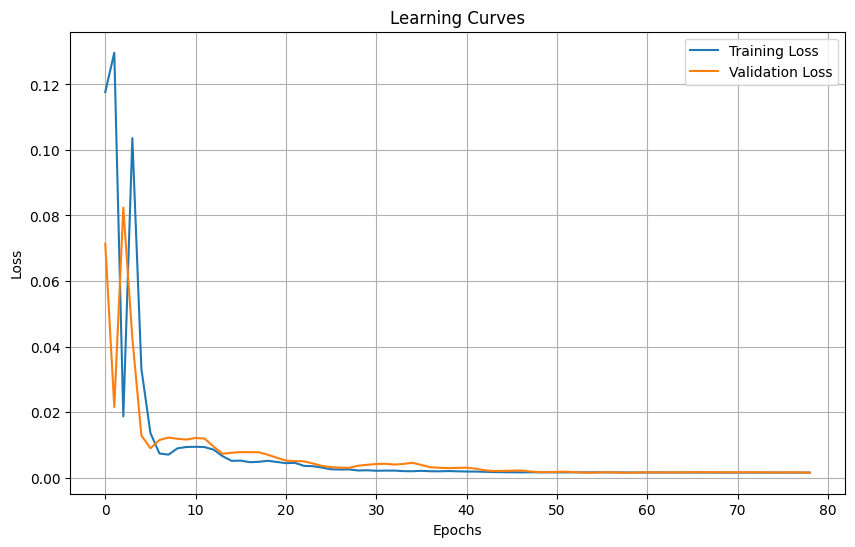

In [6]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=20,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 1.0
encoding_dim = 8
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

def custom_loss(y_true, y_pred):
    alpha = 0.05
    # Extract the first entry (expected value of theta) from y_pred
    return losses.mse(y_true, y_pred[:,0:1])+alpha*(y_pred[:, 1:2])

kqm_model.kqm_class_encoded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=custom_loss
    )

np.random.seed(42)
indices = np.random.choice(X.shape[0], size=n_comp, replace=False)
selected_samples = X[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0)[:, 0].reshape(-1, 1))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X, y,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

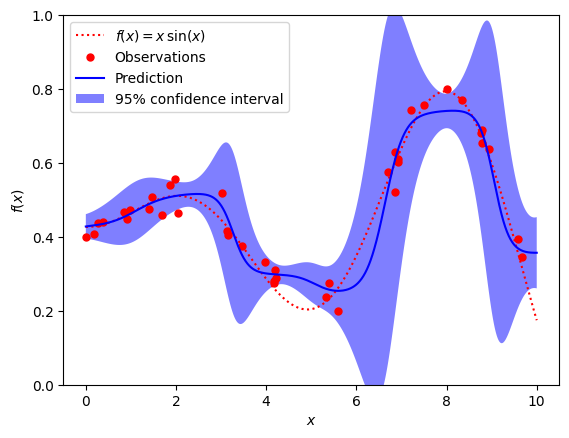

(1000, 1)


In [7]:
pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

### Next code is just in case we are dealing with a dense encoder before KQM

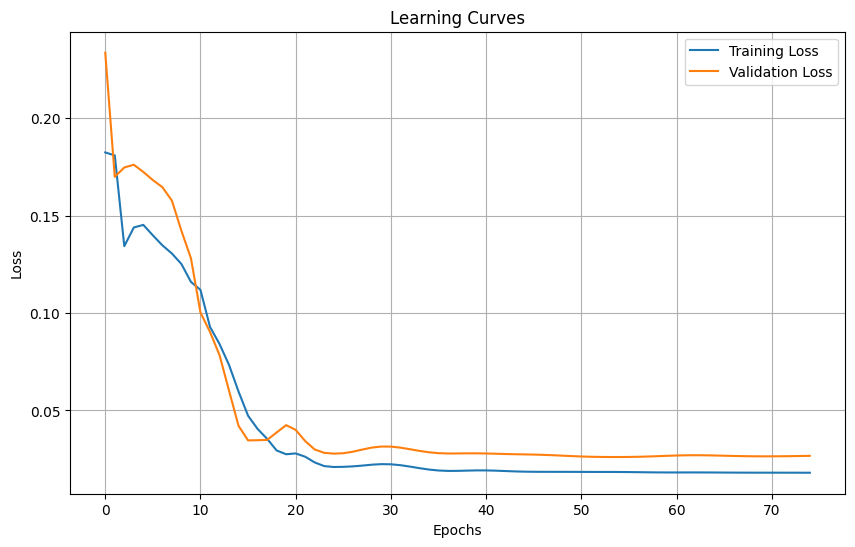

In [8]:
stoppping_b = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=20,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

#kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer)
kqm_model.encoder_aux.trainable = True
kqm_model.kqm_class_out.compile(
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.mse)
pred[:, 1]
kqm_model.kqm_unit_out.c_x.assign(kqm_model.encoder_aux.predict(selected_samples, verbose=0));

if kernel == 'rbf':
  encoded_x = kqm_model.encoder_aux.predict(X, verbose=0)
  distances = metrics.pairwise_distances(encoded_x)
  kqm_model.kernel_out.sigma.assign(np.mean(distances))


history_b = kqm_model.kqm_class_out.fit(X, y,
          validation_split = 0.2,
          epochs=500,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_b])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history_b.history['loss'], label='Training Loss')
plt.plot(history_b.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

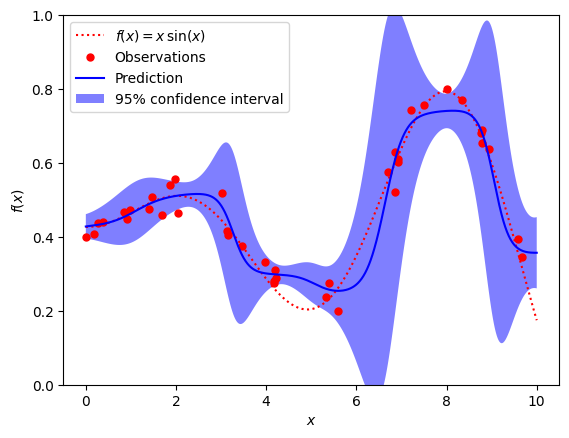

(1000, 1)


In [9]:
pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

# Initializing weights `c_y`

### With no-training

/tmp/ipykernel_170946/4007701408.py:43: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(pred[:, 1])


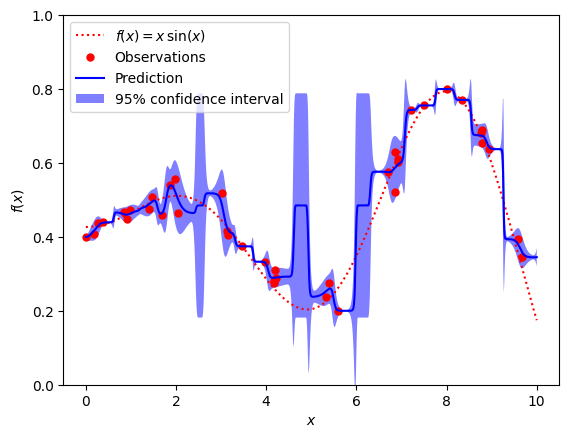

(1000, 1)


In [10]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.1
encoding_dim = 8
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

def custom_loss(y_true, y_pred):
    alpha = 0.05
    # Extract the first entry (expected value of theta) from y_pred
    return losses.mse(y_true, y_pred[:,0:1])+alpha*(y_pred[:, 1:2])

kqm_model.kqm_class_encoded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=custom_loss
    )

np.random.seed(42)
indices = np.random.choice(X.shape[0], size=n_comp, replace=False)
selected_samples = X[indices]
selected_labels = y[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0)[:, 0].reshape(-1, 1))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))

pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

### Training

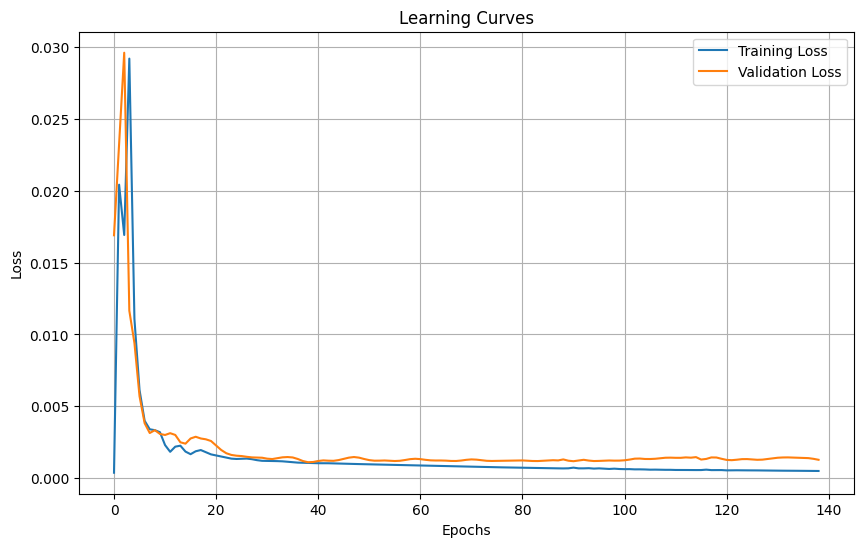

In [11]:
history = kqm_model.kqm_class_encoded.fit(X, y,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

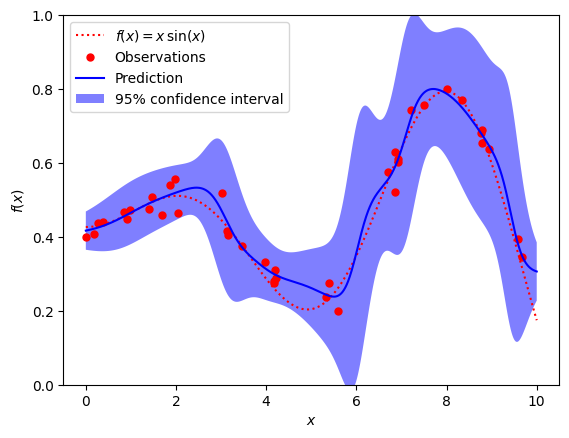

(1000, 1)


In [12]:
pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

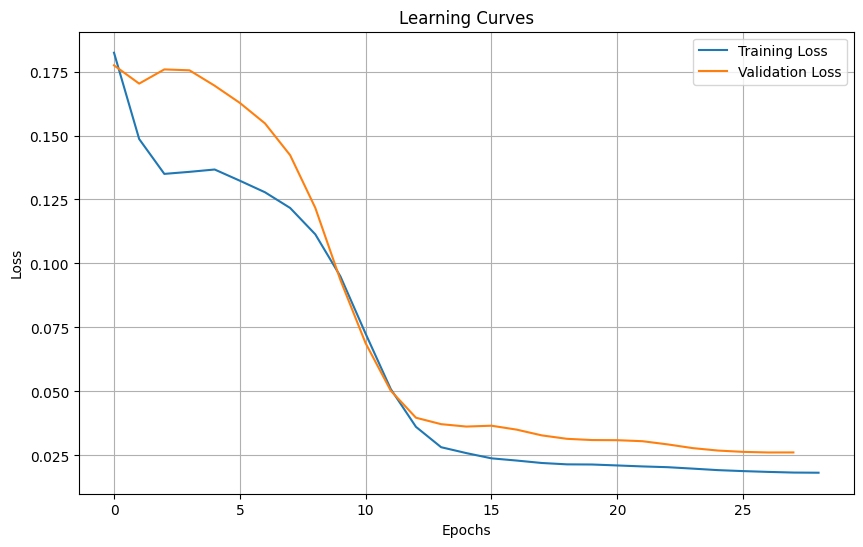

In [13]:
stoppping_b = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=20,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

#kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer)
kqm_model.encoder_aux.trainable = True
kqm_model.kqm_class_out.compile(
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.mse)
pred[:, 1]
kqm_model.kqm_unit_out.c_x.assign(kqm_model.encoder_aux.predict(selected_samples, verbose=0));

if kernel == 'rbf':
  encoded_x = kqm_model.encoder_aux.predict(X, verbose=0)
  distances = metrics.pairwise_distances(encoded_x)
  kqm_model.kernel_out.sigma.assign(np.mean(distances))


history_b = kqm_model.kqm_class_out.fit(X, y,
          validation_split = 0.2,
          epochs=500,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_b])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history_b.history['loss'], label='Training Loss')
plt.plot(history_b.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

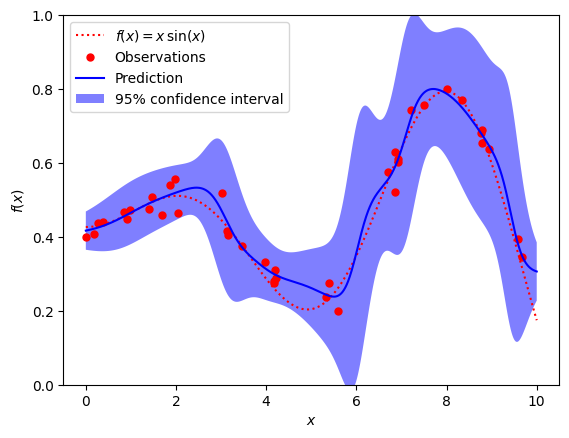

(1000, 1)


In [14]:
pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

# Anothe example

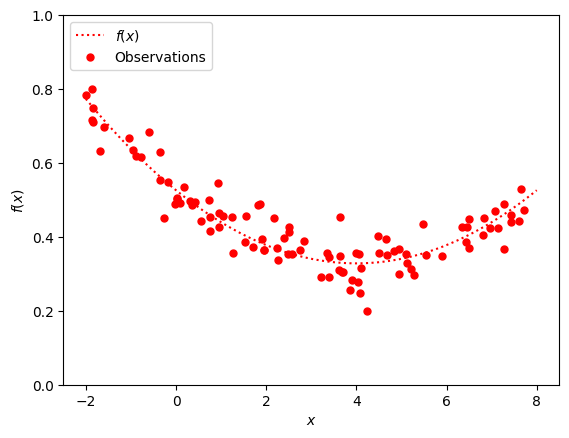

(1000, 1)


In [15]:
def f(x):
    """The function to predict."""
    return 6*(x-4)**2+20

x = np.atleast_2d(np.linspace(-2, 8, 1000)).T

X = 10* np.random.random(100) - 2
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 15 + 15.0 * np.random.random(y.shape[0])
noise = np.random.normal(0, dy)
y += noise
scaler = MinMaxScaler((0.2, 0.8))
y = scaler.fit_transform(y.reshape(-1, 1)).ravel()

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

In [16]:
n_comp = 100

In [17]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(1,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        # Extract the component weights and vectors from rho_y
        weights = rho_y[:, :, 0]  # shape: (batch_size, n_comp)
        vectors = rho_y[:, :, 1:]  # shape: (batch_size, n_comp, dim_y)
        
        # Normalize vectors
        vectors_norm = tf.sqrt(tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True))
        normalized_vectors = vectors / vectors_norm
        
        # Calculate theta from the first entry of each normalized vector
        first_entry = normalized_vectors[:, :, 0]  # shape: (batch_size, n_comp)
        thetas = tf.acos(first_entry)  # shape: (batch_size, n_comp)
        
        # Normalize weights to sum to 1
        weights_sum = tf.reduce_sum(weights, axis=-1, keepdims=True)
        normalized_weights = weights / weights_sum
        # Compute the expected value of theta
        expected_theta = tf.reduce_sum(thetas * normalized_weights, axis=-1)  # shape: (batch_size,)
        # Compute the expected value of theta squared
        expected_theta_squared = tf.reduce_sum(tf.square(thetas) * normalized_weights, axis=-1)  # shape: (batch_size,)       
        # Compute the variance using E[X²] - E[X]²
        variance_theta = expected_theta_squared - tf.square(expected_theta)  # shape: (batch_size,)        
        # Concatenate the expected value and variance
        output = tf.stack([expected_theta, variance_theta], axis=-1)  # shape: (batch_size, 2)    
        #return Model(inputs, output), kqm_unit, kernel
        return Model(inputs, output), kqm_unit, kernel
        
        #probs = kqm.dm2discrete(rho_y)
        #probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        #theta = tf.acos(probs_0_sqrt)
        #return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

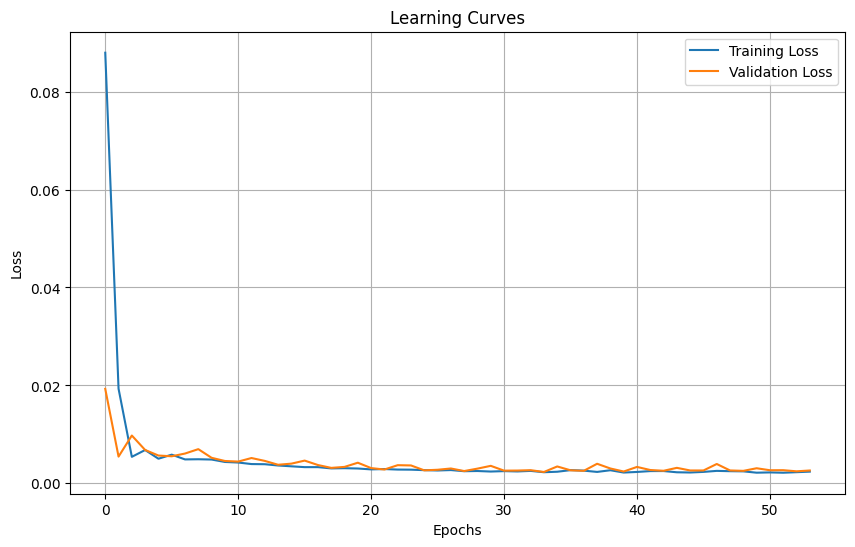

In [18]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=20,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 1
encoding_dim = 8
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

def custom_loss(y_true, y_pred):
    alpha = 0.05
    # Extract the first entry (expected value of theta) from y_pred
    return losses.mse(y_true, y_pred[:,0:1])+alpha*(y_pred[:, 1:2])

kqm_model.kqm_class_encoded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=custom_loss
    )

np.random.seed(42)
indices = np.random.choice(X.shape[0], size=n_comp, replace=False)
selected_samples = X[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0)[:, 0].reshape(-1, 1))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X, y,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

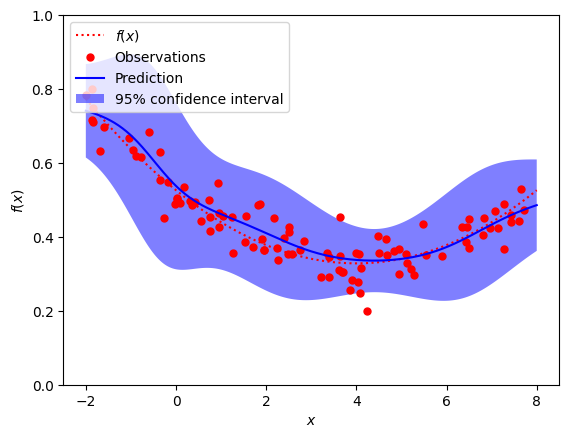

(1000, 1)


In [19]:
pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

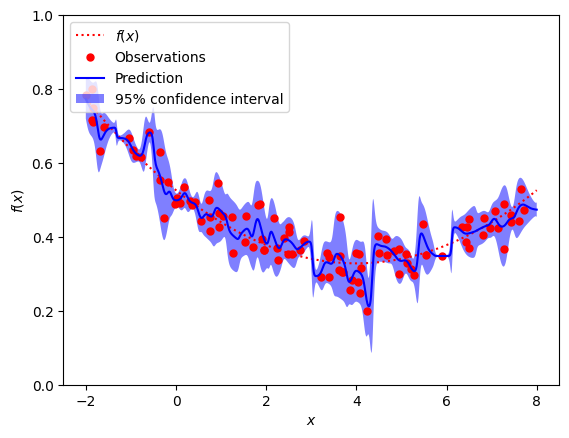

(1000, 1)


In [20]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 1
encoding_dim = 8
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

def custom_loss(y_true, y_pred):
    alpha = 0.05
    # Extract the first entry (expected value of theta) from y_pred
    return losses.mse(y_true, y_pred[:,0:1])+alpha*(y_pred[:, 1:2])

kqm_model.kqm_class_encoded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=custom_loss
    )

np.random.seed(42)
indices = np.random.choice(X.shape[0], size=n_comp, replace=False)
selected_samples = X[indices]
selected_labels = y[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0)[:, 0].reshape(-1, 1))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))

pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)

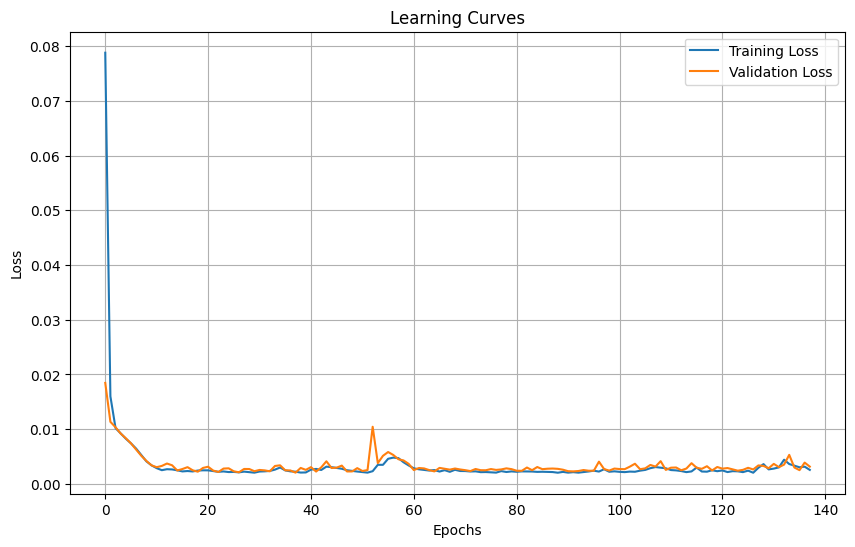

In [21]:
history = kqm_model.kqm_class_encoded.fit(X, y,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

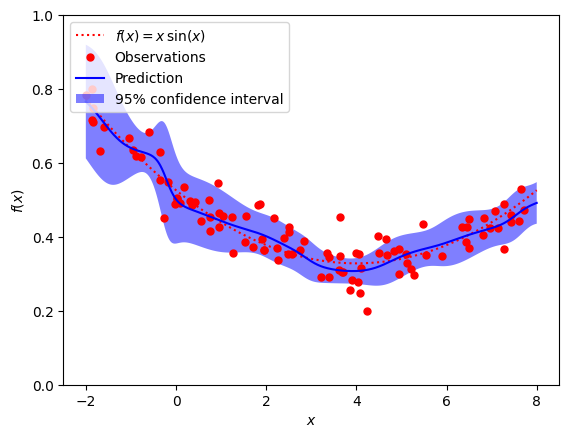

(1000, 1)


In [22]:
pred = kqm_model.kqm_class_encoded.predict(x, verbose = 0)

y_pred = pred[:, 0]
sigma = np.sqrt(pred[:, 1])

plt.figure()
plt.plot(x, scaler.transform(f(x)), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill_between(x[:,0], y_pred - 1.9600 * sigma, y_pred + 1.9600 * sigma,
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()
print(x.shape)